In [13]:
%matplotlib inline

from IPython.core.pylabtools import figsize
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats

Let's say we have two versions of a signup page and we want to determine which version gives us a better conversion rate. In the real-world we can never determine the true conversion rate. Instead we rely on observing some data and from that data we determine the observed converion rate. 

Let's take a look at a simple example.

In [5]:
# The true conversion rate for version A
p_a_true = 0.05

In [8]:
# Number of observations
N = 1500

# Generate random observations
obs = stats.bernoulli.rvs(p_a_true, size=N)
print("The observed conversion rate is {}".format(obs.sum()/N))

The observed conversion rate is 0.056


In [9]:
# Let's build a bayesian model to determine the uncertainty in our observed conversion rate

# Define a prior
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)  # prior for our bernoulli model
    obs_post = pm.Bernoulli("obs", p, observed=obs)
    step = pm.Metropolis()
    trace = pm.sample(18000, step)
    burned_trace = trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p]
Sampling 2 chains, 0 divergences: 100%|██████████| 37000/37000 [00:06<00:00, 6042.40draws/s]
The number of effective samples is smaller than 25% for some parameters.


/Users/ankurm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


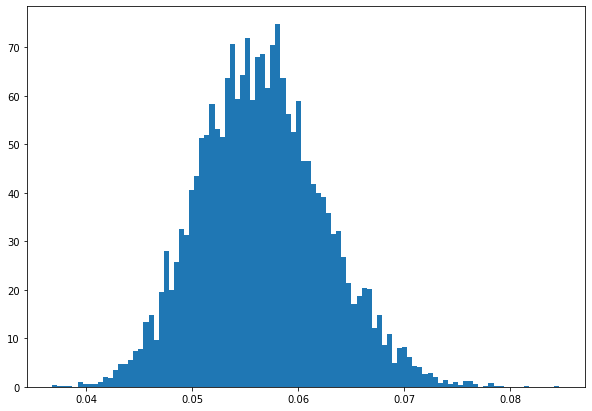

Mean of observed conversion rate 0.05659909109131139


In [15]:
figsize(10, 7)
plt.hist(burned_trace['p'], bins=100, normed=True)
plt.show()

print("Mean of observed conversion rate {}".format(burned_trace['p'].mean()))

The posterior distribution puts most weight around the value that was observed in our data. Additionally, the distribution also helps us determine the uncertainty in the observed value. The model applies some weights to the tails as well. 

Now let's perform the same analysis for version B. But what we are most interested in analyzing is which version is better. So let us define this variable as `delta = conversion rate A - conversion rate B`.

In [20]:
# Define the true covnersion rates
p_true_a = 0.05
p_true_b = 0.03

# Number of observations for each version
N_a = 1500
N_b = 750

# Simulate some data
obs_a = stats.bernoulli.rvs(p_true_a, size=N_a)
obs_b = stats.bernoulli.rvs(p_true_b, size=N_b)

print("Observed conversion rate for version A {}".format(obs_a.mean()))
print("Observed conversion rate for version B {}".format(obs_b.mean()))

Observed conversion rate for version A 0.05466666666666667
Observed conversion rate for version B 0.02666666666666667


In [21]:
# Determine the posterior distributions
with pm.Model() as model:
    # Define the priors
    p_a = pm.Uniform('p_a', lower=0, upper=1)
    p_b = pm.Uniform('p_b', lower=0, upper=1)
    
    delta = pm.Deterministic('delta', p_a - p_b)
    
    post_obs_a = pm.Bernoulli('obs_a', p_a, observed=obs_a)
    post_obs_b = pm.Bernoulli('obs_b', p_b, observed=obs_b)
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_b]
>Metropolis: [p_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 41000/41000 [00:10<00:00, 3955.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


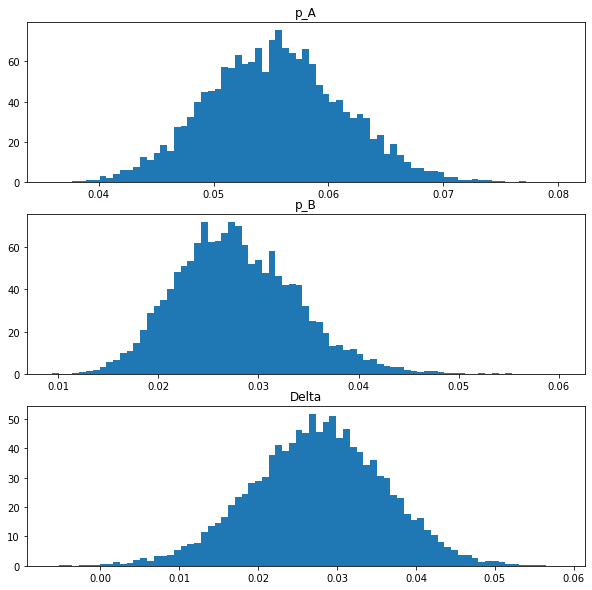

In [26]:
figsize(10, 10)

plt.subplot(311)
plt.hist(burned_trace['p_a'], bins=75, density=True)
plt.title('p_A')

plt.subplot(312)
plt.hist(burned_trace['p_b'], bins=75, density=True)
plt.title('p_B')

plt.subplot(313)
plt.hist(burned_trace['delta'], bins=75, density=True)
plt.title('Delta')

plt.show()

In [28]:
print("Probability version A is worse than B {}".format(np.mean(burned_trace['delta'] < 0)))
print("Probability version A is better than B {}".format(np.mean(burned_trace['delta'] > 0)))

Probability version A is worse than B 0.0010263157894736842
Probability version A is better than B 0.9989736842105263


The probability that version A is better than B is 0.999, so we can be confident that version A is better than version B despite version B having half the number of observations as version A.